In [1]:
import json
import os

from analysis import *
from plot_main import *

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})


### Load model and run simulation on experimental reward schedule and stimuli

In [3]:
# exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/dual_hierarchical_good_based/'
# os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')
os.chdir('/Volumes/f005d7d/attn-rnn/Attn-WM-RNN')
exp_dir = 'exp/dual_hierarchical_good_based'

f = open(os.path.join(exp_dir, 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.25
choice_start = 0.4
rwd_start = 0.6
stim_end = 0.75

exp_times = {
    'start_time': -ITI,
    'end_time': stim_end,
    'stim_onset': 0.0,
    'stim_end': stim_end,
    'rwd_onset': rwd_start,
    'rwd_end': stim_end,
    'choice_onset': choice_start,
    'choice_end': rwd_start,
    'total_time': ITI+stim_end,
    'dt': args['dt']}
log_interval = 1
task_mdprl = MDPRL(exp_times, args['input_type'])
print('loaded task')

loaded args
loaded task


In [4]:
input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

input_unit_group = {
    'feat': [args['stim_dim']*args['stim_val']], 
    'feat+obj': [args['stim_dim']*args['stim_val'], args['stim_val']**args['stim_dim']], 
    'feat+conj+obj': [args['stim_dim']*args['stim_val'], args['stim_dim']*args['stim_val']*args['stim_val'], args['stim_val']**args['stim_dim']]
}[args['input_type']]

if args['attn_type']!='none':
    if args['input_type']=='feat':
        channel_group_size = [args['stim_val']]*args['stim_dim']
    elif args['input_type']=='feat+obj':
        channel_group_size = [args['stim_val']]*args['stim_dim'] + [args['stim_val']**args['stim_dim']]
    elif args['input_type']=='feat+conj+obj':
        channel_group_size = [args['stim_val']]*args['stim_dim'] + [args['stim_val']*args['stim_val']]*args['stim_dim'] + [args['stim_val']**args['stim_dim']]
else:
    channel_group_size = [input_size]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 'num_options': num_options,
                'plastic': args['plas_type']=='all', 'attention_type': args['attn_type'], 'activation': args['activ_func'],
                'dt': args['dt'], 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 'channel_group_size': channel_group_size,
                'c_plasticity': None, 'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'input_unit_group': input_unit_group, 'sep_lr': args['sep_lr'], 'plastic_feedback': args['plastic_feedback'],
                'value_est': 'policy' in args['task_type'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'spatial_attn_agg': args['spatial_attn_agg'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1), 'input_plastic': not args['input_plas_off']}

model = HierarchicalRNN(**model_specs)
print(model)
for n, p in model.named_parameters():
    print(n, p.numel())

state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth.tar'), map_location=torch.device('cpu'))['model_state_dict']
print(model.load_state_dict(state_dict))

HierarchicalRNN(
  (rnn): PlasticLeakyRNNCell(
    (x2h): EILinear()
    (aux2h): EILinear()
    (h2h): EILinear()
  )
  (h2o): EILinear()
)
rnn.kappa_rec 57600
rnn.x2h.weight 15120
rnn.aux2h.weight 6960
rnn.h2h.weight 57600
rnn.h2h.bias 240
h2o.weight 1728
<All keys matched successfully>


In [6]:
# run model

import pickle

if os.path.exists('exp/test_activities'):
    print('found previous record pickle, loading previous results')
    with open('exp/test_activities', 'rb') as f:
        losses, losses_means, losses_stds, all_saved_states, all_indices, all_probs = pickle.load(f)
    print('loaded previous results')
else:
    losses, losses_means, losses_stds, all_saved_states, all_indices, all_probs = run_model(args, model, task_mdprl)
    print('simulation complete')
    with open('exp/test_activities', 'wb') as f:
        pickle.dump([losses, losses_means, losses_stds, all_saved_states, all_indices, all_probs], f)
    print('saved results to exp/test_activities')


# stim_probs_ordered = all_probs.reshape(27, 10)[all_indices[:,i,0]]

# selectivity, sort_inds, cluster_label = unit_selectivity(all_saved_states['hs'], np.argmax(stim_probs_ordered, axis=-1), 
#                                                     e_size=int(args['e_prop']*args['hidden_size']))

found previous record pickle, loading previous results
loaded previous results


### Learning Curve

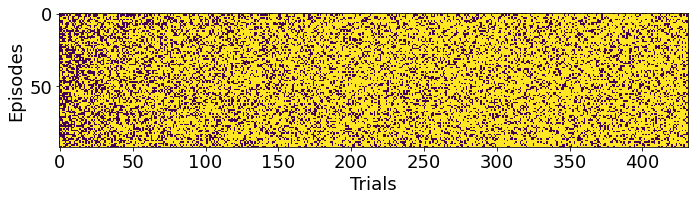

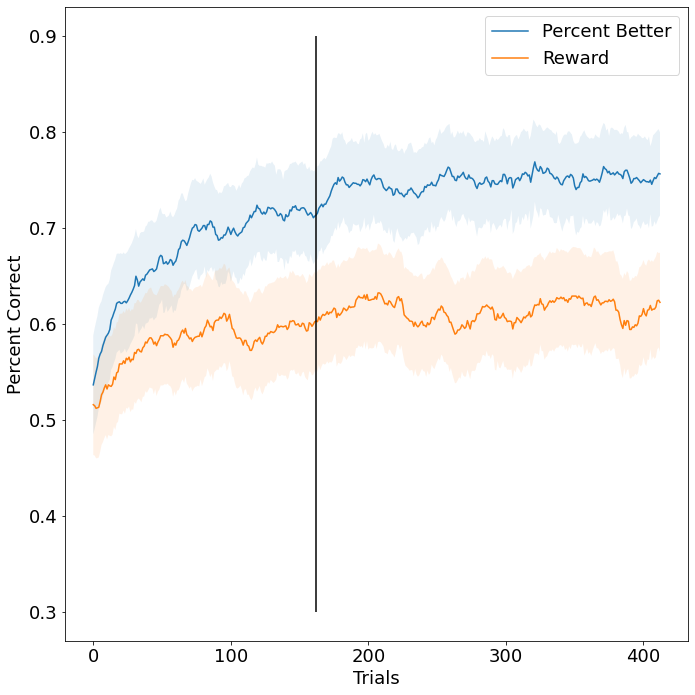

In [7]:
plot_learning_curve(args, losses, losses_means, losses_stds)

In [10]:
def targeted_dimensionality_reduction(hs, xs, do_zscore=False, denoise=False, ortho=False, n_jobs=1):
    n_trials, n_time_steps, n_batch, n_hidden = hs.shape
    assert(xs.shape[:2]==(n_trials, n_batch))
    n_vars = xs.shape[-1]

    # z-score the hidden activity
    if do_zscore:
        hs = zscore(hs.reshape(n_time_steps*n_trials, n_hidden), axis=0).reshape(n_time_steps, n_trials, n_hidden)

    # denoise with PCA
    if denoise:
        U, S, Vh = np.linalg.svd(hs) # n_time_steps*n_trials x n_hidden, n_hidden X n_hidden, n_hidden X n_hidden
        npca = 0
        while np.cumsum(S[:npca]**2)/np.sum(S**2) < 0.95:
            npca += 1
        D = Vh[:npca].T@Vh[:npca]

    lrs = []
    betas = []
    for i in tqdm.tqdm(range(n_trials)):
        lrs.append([])
        betas.append([])
        for j in range(n_time_steps):
            # cross validate alpha at each timestep? should i do this?
            lrs[-1].append(RidgeCV(alphas=(1e-3, 1e-2, 1e-3, 1, 10), fit_intercept=not do_zscore).fit(xs[i], hs[i,j]))
            betas[-1].append(lrs[-1][-1].coef_)
        betas[-1] = np.stack(betas[-1])
            
    betas = np.stack(betas)
    
    if ortho:
        raise NotImplementedError('Not using orthogonal functionality')
        coeff_norms = np.linalg.norm(betas, axis=1) # n_time_steps X n_feats
        coeff_max = betas[np.argmax(coeff_norms, axis=0), :, np.arange(n_vars)] # argmax has size n_feats
        assert coeff_max.shape==(n_hidden, n_vars)
        Q, R = np.linalg.qr(coeff_max)
        coeff_max = Q
    
    return lrs, betas

def get_CPD(hs, xs, full_model, channel_groups):
    n_trials, n_time_steps, n_batch, n_hidden = hs.shape
    assert(xs.shape[:2]==(n_trials, n_batch))
    n_vars = xs.shape[-1]
        
    assert(np.sum(channel_groups)==n_vars)
    channel_groups = np.cumsum(channel_groups)
    channel_groups = np.insert(channel_groups, 0, 0)
    # manually calculate SSE for categorical IVs

    cpd = np.empty((n_trials, n_time_steps, len(channel_groups)-1, n_hidden))

    for i in tqdm.tqdm(range(n_trials)):
        for j in range(n_time_steps):
            sse = np.sum((full_model[i][j].predict(xs[i]) - hs[i,j])**2, axis=0)
            for k in range(1, len(channel_groups)):
                X_k = xs[i].copy()
                X_k[:,channel_groups[k-1]:channel_groups[k]] = 0 # remove one factor
                sse_X_k = np.sum((full_model[i][j].predict(X_k) - hs[i,j])**2, axis=0)
                cpd[i,j,k-1,:]=(sse_X_k-sse)/(sse_X_k+1e-6)

    return cpd

def plot_tdr(hs, stim_order, stim_encoding, stim_probs):
    '''
    (1) regress hs activity (z-scored) with stimulus encoding (F/C/O)
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''

    n_trials, n_timesteps, n_batch, n_hidden = hs.shape
    assert(stim_order.shape[:2]==(n_trials, n_batch))
    n_choice = stim_order.shape[2]
    assert(stim_encoding.shape==(27, 63))
    # get stimulus encoding
    stim_encoding_ordered = stim_encoding[stim_order.reshape(n_trials*n_batch*n_choice),:].reshape(n_trials, n_batch, n_choice, 63)
    
    stim_encoding_ordered = stim_encoding_ordered.sum(axis=2) # sum over choices to get location independent active feat/conj/obj

    # get stimulus probablity
    # stim_probs_ordered = []
    # for i in range(7):
    #     stim_probs_ordered.append(stim_probs[i,stim_order.reshape(n_trials*n_batch*n_choice)].reshape(n_trials, n_batch, n_choice, 1))
    # stim_probs_ordered = np.concatenate(stim_probs_ordered, axis=-1)
    # assert(stim_probs_ordered.shape==(n_trials, n_batch, n_choice, 7))
    # stim_probs_ordered = np.concatenate([
    #     stim_probs_ordered.sum(2, keepdim=True), 
    #     np.abs(stim_probs_ordered[0:1]-stim_probs_ordered[1:2]), 
    #     stim_probs_ordered.max(2, keepdim=True)
    # ], axis=2)
    # assert(stim_probs_ordered.shape==(n_trials, n_batch, 3, 7))

    # xs = np.concatenate([stim_encoding_ordered, stim_probs_ordered], axis=-1)

    xs = stim_encoding_ordered
    num_vars = stim_encoding_ordered.shape[-1]
    hs = hs.numpy()
    
    print('Calculating regression')
    all_lrs, all_betas = targeted_dimensionality_reduction(hs, xs)

    print('Calculating CPDs')
    channel_groups = np.array([3, 3, 3, 9, 9, 9, 27])
    all_cpds = get_CPD(hs, xs, all_lrs, channel_groups)

    split_trials = 4
    all_cpds = all_cpds.reshape(4, n_trials//4, n_timesteps, len(channel_groups), n_hidden)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return all_lrs, all_cpds, all_betas

Regression eq: $h_t = \sum_{i=1}^3 \beta^F_{it}F_{it} + \sum_{i=1}^3 \beta^C_{it} C_{it} +\beta^O_{it}O_{it} + \epsilon_t$

In [16]:
all_lrs, all_cpds, all_betas = plot_tdr(all_saved_states['hs'], all_indices, task_mdprl.stim_encoding('all_onehot'), all_probs)

Calculating regression


100%|██████████| 432/432 [00:17<00:00, 25.38it/s]


Calculating CPDs


100%|██████████| 432/432 [00:42<00:00, 10.16it/s]


In [ ]:
# from matplotlib.pyplot import figure


figure(figsize=(20, 16), dpi=300)
fig, axes = plt.subplots(4, 5)
for i in range(20):
    axes[i//5][i%5].bar(range(160), results[20][0]['cp_tensor'].factors[2][sort_inds,i], label=range(20))
# plt.ylim([-1, 1])
# plt.legend()
plt.tight_layout()


### Plot Initial Connectivity

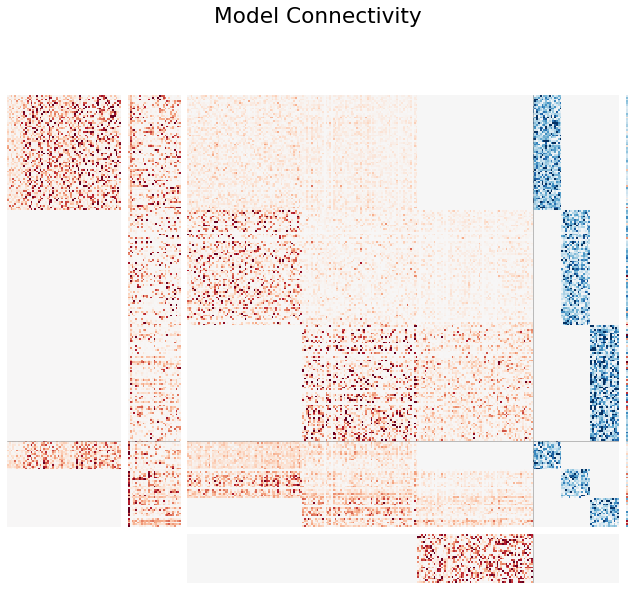

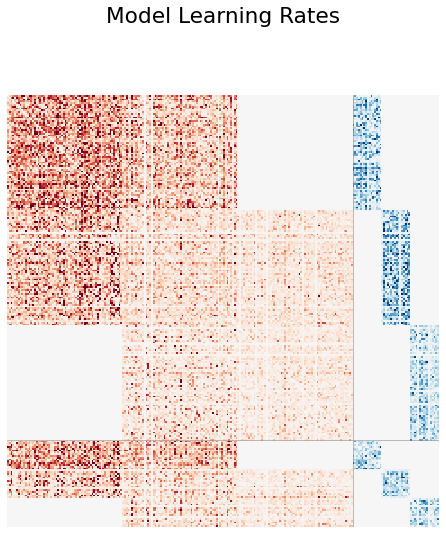

In [8]:
from matplotlib.pyplot import figure
plot_connectivity_lr(torch.arange(240), 
                             x2hw=model.rnn.x2h.effective_weight().detach(),
                             h2hw=model.rnn.h2h.effective_weight().detach(),
                             hb=state_dict['rnn.h2h.bias'].detach(),
                             h2ow=torch.cat([torch.zeros(27, 128), model.h2o.effective_weight().detach(), torch.zeros(27, 16*3)], dim=1),
                             aux2h=model.rnn.aux2h.effective_weight().detach(),
                             kappa_rec=model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

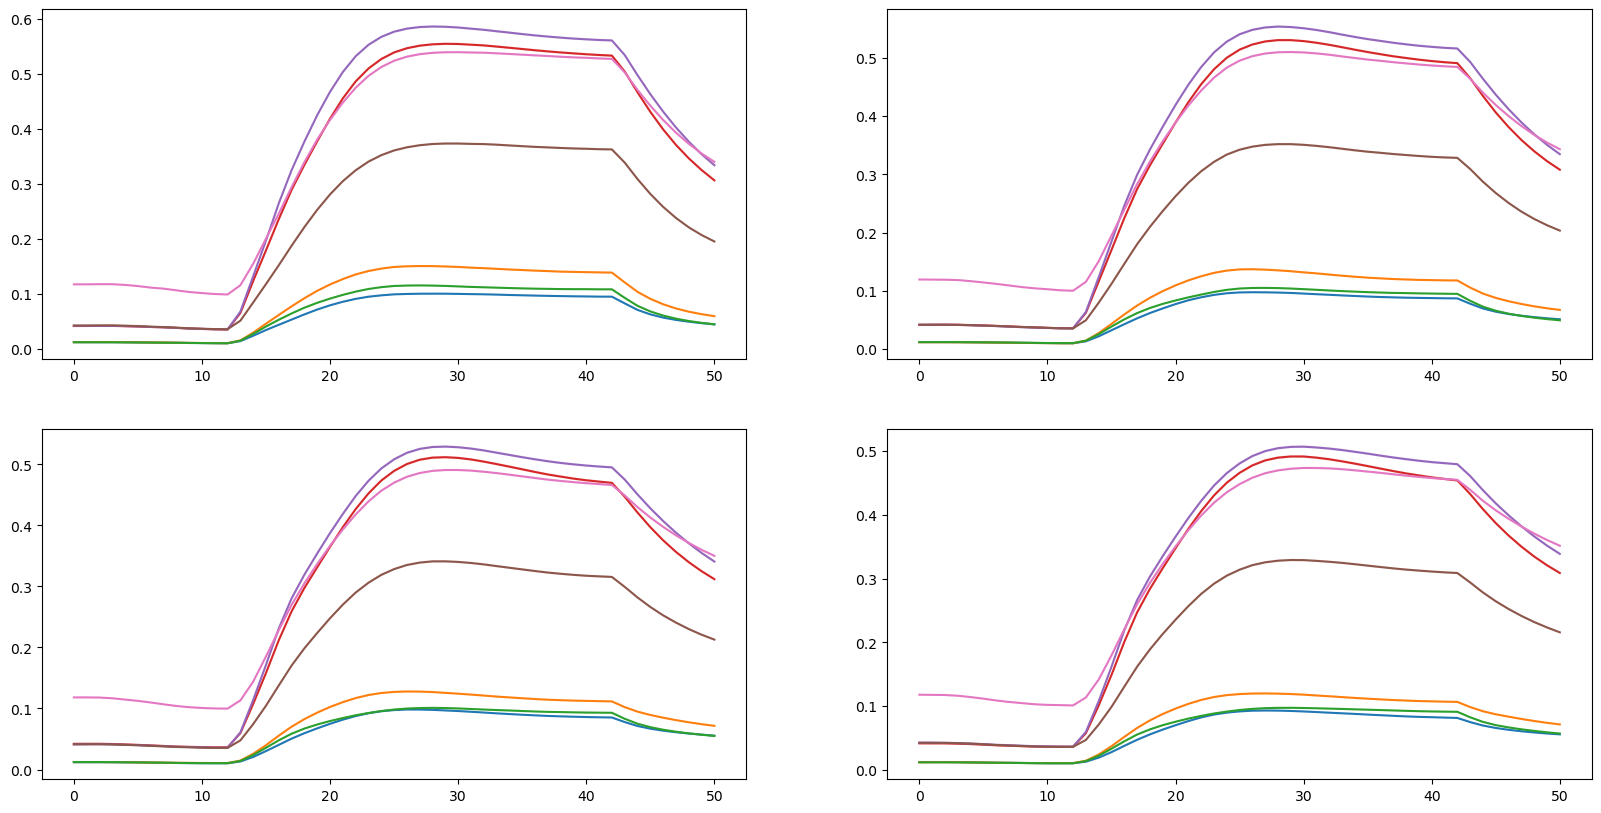

In [346]:
# for i in range(4):
#     plt.subplot(410+i+1).plot(all_cpds[i,:,:,:,:].mean((0,3)));
#     plot
#     plt.ylim([-0.05, 1.05])
# plt.tight_layout()

fig, axes = plt.subplots(2, 2)
for i in range(4):
    for j in range(7):
        plot_mean_and_std(axes[i//2, i%2], all_cpds[i*108:(i+1)*108,:,j,:].mean((0, 2)), all_cpds[i*108:(i+1)*108,:,j,:].std((0, 2))/np.sqrt(432//4*93), 
                      label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])

(432, 51, 240, 63)


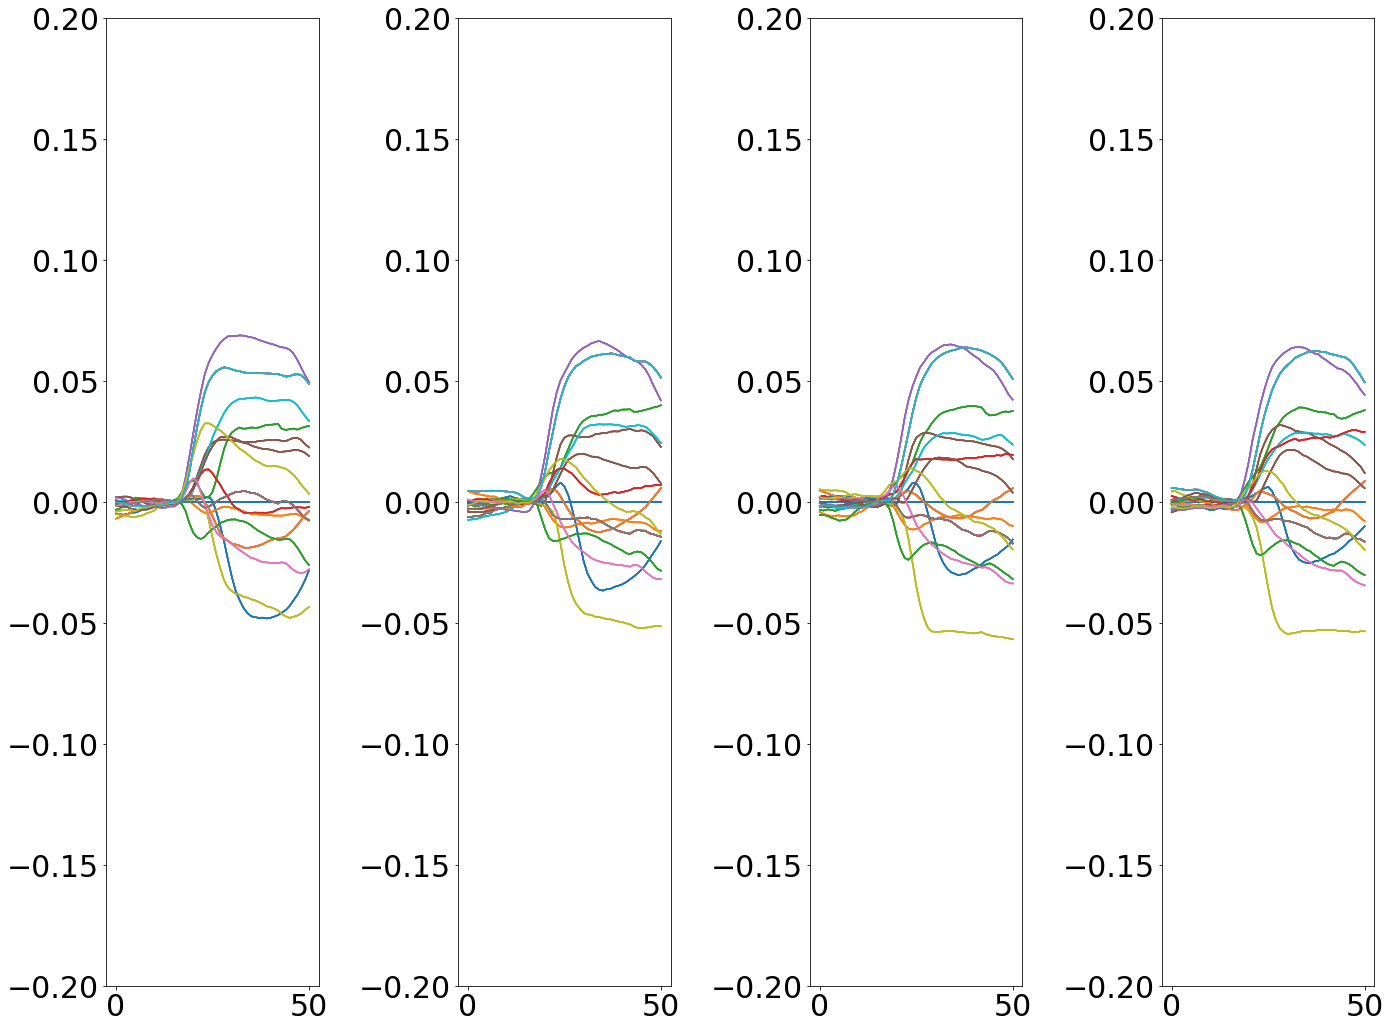

In [107]:
print(all_betas.shape)
fig, axes = plt.subplots(1,4)
sub_hiddens =  np.random.randint(128, 192, size=(20,))
for i in range(4):
    for j in range(4):
#         axes[i,j].imshow(all_betas[108*i:108*(i+1),:,np.random.randint(64),:].mean(0).T, vmin=-0.1, vmax=0.1, 
#                                   interpolation='nearest', cmap='coolwarm', aspect='auto');
        axes[j].plot(all_betas[108*j:108*(j+1),:,sub_hiddens,8].mean((0)))
        # axes[j].plot(all_betas[108*i:108*(i+1),:,np.random.randint(192),1].mean((0)), c='b')
        # axes[j].plot(all_betas[108*i:108*(i+1),:,np.random.randint(192),2].mean((0)), c='g')
        axes[j].set_ylim([-0.2, 0.2])
plt.tight_layout()

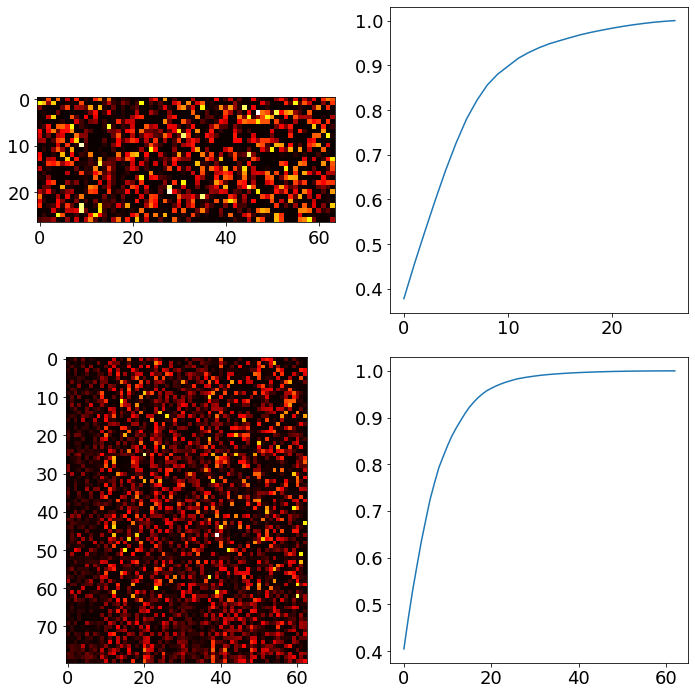

In [131]:
fig = plt.figure()
plt.subplot(221).imshow(model.h2o.effective_weight().detach(), cmap='hot')
u_out, s_out, vh_out = np.linalg.svd(model.h2o.effective_weight().detach(), full_matrices=False)
plt.subplot(222).plot(np.cumsum(s_out**2)/np.sum(s_out**2))

x2h = model.rnn.x2h.effective_weight().detach()[list(range(64))+list(range(64*3, 64*3+16)),:]
plt.subplot(223).imshow(x2h, cmap='hot')
u_in, s_in, vh_in = np.linalg.svd(x2h, full_matrices=False)
plt.subplot(224).plot(np.cumsum(s_in**2)/np.sum(s_in**2))

plt.tight_layout()

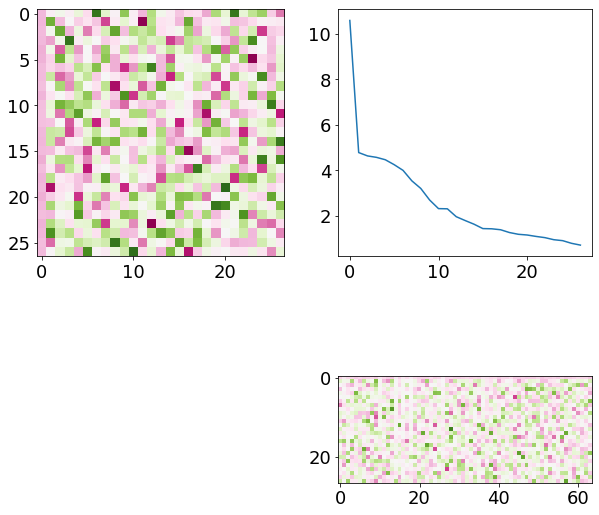

In [73]:
plt.subplot(221).imshow(u_out, vmin=-0.5, vmax=0.5, cmap='PiYG')
plt.subplot(222).plot(s_out)
plt.subplot(224).imshow(vh_out, vmin=-0.5, vmax=0.5, cmap='PiYG')

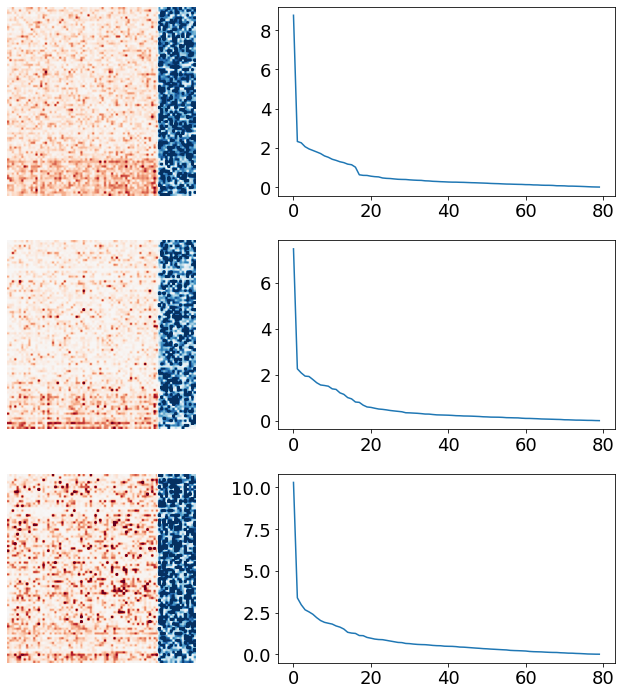

In [9]:
e_hidden_size = 64
i_hidden_size = 16

h2h = model.rnn.h2h.effective_weight().detach()

rec_intra = []
us = []
vhs = []
ss = []
for i in range(3):
    rec_intra.append(h2h[list(range(i*e_hidden_size, (i+1)*e_hidden_size))+\
                         list(range(3*e_hidden_size+i*i_hidden_size, 3*e_hidden_size+(i+1)*i_hidden_size))]
                      [:,list(range(i*e_hidden_size, (i+1)*e_hidden_size))+\
                         list(range(3*e_hidden_size+i*i_hidden_size, 3*e_hidden_size+(i+1)*i_hidden_size))])
    u, s, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
    us.append(u)
    vhs.append(vh)
    ss.append(s)
    
wlim = 0.25    
fig, axes = plt.subplots(3, 2)
for i in range(3):
    axes[i,0].imshow(rec_intra[i], vmax=wlim, vmin=-wlim, cmap='RdBu_r')
    axes[i,1].plot(ss[i])
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].axis('off')
plt.tight_layout()
plt.show()

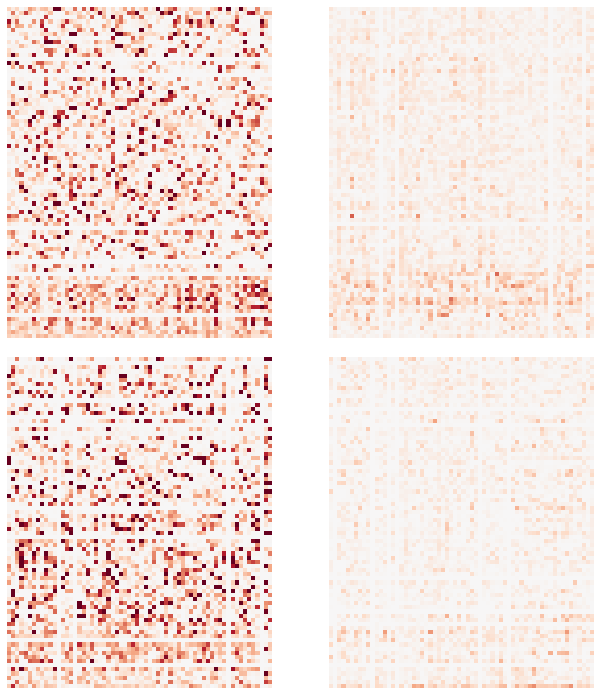

In [10]:
rec_inter_ff = []
rec_inter_fb = []
for i in range(2):
    rec_inter_ff.append(h2h[list(range((i+1)*e_hidden_size, (i+2)*e_hidden_size))+\
                            list(range(3*e_hidden_size+(i+1)*i_hidden_size, 3*e_hidden_size+(i+2)*i_hidden_size))]
                         [:,list(range(i*e_hidden_size, (i+1)*e_hidden_size))])
    rec_inter_fb.append(h2h[list(range(i*e_hidden_size, (i+1)*e_hidden_size))+\
                            list(range(3*e_hidden_size+i*i_hidden_size, 3*e_hidden_size+(i+1)*i_hidden_size))]
                         [:,list(range((i+1)*e_hidden_size, (i+2)*e_hidden_size))])
    
fig, axes = plt.subplots(2,2)
wlim = 0.5
for i in range(2):
    axes[i,0].imshow(rec_inter_ff[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].axis('off')
    axes[i,1].imshow(rec_inter_fb[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].axis('off')
plt.tight_layout()

In [ ]:
# TODO: fit behavioral model to network

In [116]:
def run_svd_time_varying_w(ws):
    trials, batch_size, post_dim, pre_dim = ws.shape
    us, ss, vhs = np.linalg.svd(ws)
    return us, ss, vhs

def participation_ratio(ss, dim=-1):
    return np.sum(ss, axis=-1)**2/np.sum(ss**2, axis=-1)

def cross_alignment_ratio(ss, us, vhs):
    '''
    ss: singular values of template matrix (..., N)
    us: upstream patterns (..., N, N)
    vhs: templates of the current matrix (..., N, N)
    
    output = ||SS\otimes V^H U_{\cdot,i}||_2/||SS||_2 \in [0, 1]^{..., N} for each column of U

    '''
    return np.sum((np.diag(ss)@vhs@us)**2, axis=-1)/np.sum(ss**2, axis=-1)

def get_sub_mats(ws, num_areas, e_hidden_size, i_hidden_size):
    trials, batch_size, post_dim, pre_dim = ws.shape
    assert((e_hidden_size+i_hidden_size)*num_areas==pre_dim and (e_hidden_size+i_hidden_size)*num_areas==post_dim)
    total_e_size = e_hidden_size*num_areas
    submats = {}
    for i in range(num_areas):
        submats[f"rec_intra_{i}"] = ws[:,:,list(range(i*e_hidden_size, (i+1)*e_hidden_size))+\
                                             list(range(total_e_size+i*i_hidden_size, total_e_size+(i+1)*i_hidden_size))]\
                                      [:,:,:,list(range(i*e_hidden_size, (i+1)*e_hidden_size))+\
                                             list(range(total_e_size+i*i_hidden_size, total_e_size+(i+1)*i_hidden_size))]

    for i in range(num_areas-1):
        submats[f"rec_inter_ff_{i}_{i+1}"] = ws[:,:,list(range((i+1)*e_hidden_size, (i+2)*e_hidden_size))+\
                                                list(range(total_e_size+(i+1)*i_hidden_size, total_e_size+(i+2)*i_hidden_size))]\
                                               [:,:,:,list(range(i*e_hidden_size, (i+1)*e_hidden_size))+\
                                                list(range(total_e_size+i*i_hidden_size, total_e_size+(i+1)*i_hidden_size))]
        submats[f"rec_inter_fb_{i+1}_{i}"] = ws[:,:,list(range(i*e_hidden_size, (i+1)*e_hidden_size))+\
                                                list(range(total_e_size+i*i_hidden_size, total_e_size+(i+1)*i_hidden_size))]\
                                               [:,:,:,list(range((i+1)*e_hidden_size, (i+2)*e_hidden_size))+\
                                                list(range(total_e_size+(i+1)*i_hidden_size, total_e_size+(i+2)*i_hidden_size))]
    return submats


def plot_subspace(ws, xs, num_areas, e_hidden_size, i_hidden_size):
    submats = get_sub_mats(ws, num_areas=num_areas, e_hidden_size=e_hidden_size, i_hidden_size=i_hidden_size)
    print('Extracted Sub-matrices')
    all_us = {}
    all_ss = {}
    all_vhs = {}

    for w_name, w_vals in submats.items():
        us, ss, vhs = run_svd_time_varying_w(w_vals)
        all_us[w_name] = us
        all_ss[w_name] = ss
        all_vhs[w_name] = vhs
        print(f'Finished SVD of {w_name}')

    # plot participation ratios for change of dimensionality through training
    fig, axes = plt.subplots(num_areas, num_areas)
    for i in range(num_areas):
        pr_rec = participation_ratio(all_ss[f"rec_intra_{i}"])
        plot_mean_and_std(axes[i, i], pr_rec.mean(1), pr_rec.std(1)/np.sqrt(pr_rec.shape[0]), label=None)
        axes[i,i].set_title(fr"Area {i} Recurrent")

    for i in range(num_areas-1):
        pr_ff = participation_ratio(all_ss[f"rec_inter_ff_{i}_{i+1}"])
        plot_mean_and_std(axes[i, i+1], pr_ff.mean(1), pr_ff.std(1)/np.sqrt(pr_ff.shape[0]), label=None)
        pr_fb = participation_ratio(all_ss[f"rec_inter_fb_{i+1}_{i}"])
        plot_mean_and_std(axes[i+1, i], pr_fb.mean(1), pr_fb.std(1)/np.sqrt(pr_fb.shape[0]), label=None)
        axes[i,i+1].set_title(fr"Area {i} $\to$ Area {i+1} FF")
        axes[i+1,i].set_title(fr"Area {i+1} $\to$ Area {i} FB")

    fig.supylabel('Participation Ratios')
    fig.supxlabel('Trials')
    
    plt.tight_layout()

    # plot dimensional alignment?
    # for each recurrent matrix's right singular vector, see how much it is accepted by its left singular vector 
    # each column of U is a dimension of the output space, match it with rows of V^T through V^TU
    # then each column of V^TU is the match between all of V^T and one column of U
    # pre-multiplying with S weighs each 
    # size (trials, batch_size, post_dim, pre_dim)

    fig, axes = plt.subplots(num_areas, num_areas)
    for i in range(num_areas):
        w_name = f"rec_intra_{i}"
        align_ratio = np.sum(all_ss[w_name]*(all_vhs[w_name]@all_us[w_name]))**2/all_ss[w_name]**2
        

    for i in range(num_areas):
        pr_rec = participation_ratio(all_ss[f"rec_intra_{i}"])
        plot_mean_and_std(axes[i, i], pr_rec.mean(1), pr_rec.std(1)/np.sqrt(pr_rec.shape[0]), label=None)
        axes[i,i].set_title(fr"Area {i} Recurrent")

    for i in range(num_areas-1):
        pr_ff = participation_ratio(all_ss[f"rec_inter_ff_{i}_{i+1}"])
        plot_mean_and_std(axes[i, i+1], pr_ff.mean(1), pr_ff.std(1)/np.sqrt(pr_ff.shape[0]), label=None)
        pr_fb = participation_ratio(all_ss[f"rec_inter_fb_{i+1}_{i}"])
        plot_mean_and_std(axes[i+1, i], pr_fb.mean(1), pr_fb.std(1)/np.sqrt(pr_fb.shape[0]), label=None)
        axes[i,i+1].set_title(fr"Area {i} $\to$ Area {i+1} FF")
        axes[i+1,i].set_title(fr"Area {i+1} $\to$ Area {i} FB")
    
    plt.tight_layout()


In [117]:
e_hidden_size = 64
i_hidden_size = 16
plot_subspace(all_saved_states['whs_final'].squeeze(), None, args['num_areas'], e_hidden_size=e_hidden_size, i_hidden_size=i_hidden_size)

NameError: name 'all_saved_states' is not defined

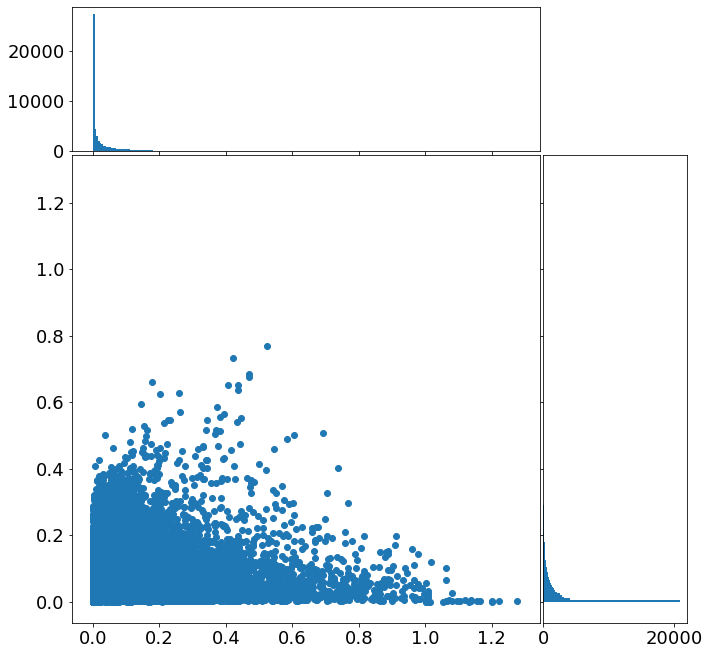

In [118]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.005
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure()

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(model.rnn.h2h.effective_weight().detach().flatten().abs().numpy(), 
            model.rnn.h2h.effective_weight(model.rnn.kappa_rec.abs()).detach().squeeze().flatten().abs().numpy(), 
            ax, ax_histx, ax_histy)

plt.show()


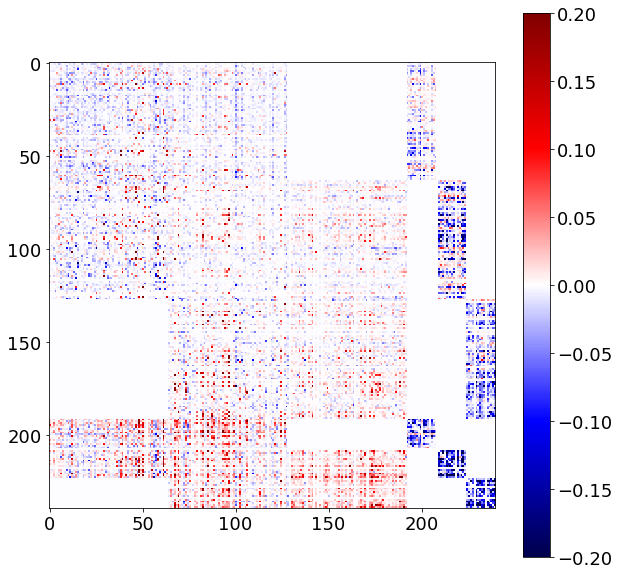

In [62]:
plt.imshow(model.rnn.h2h.effective_weight(all_saved_states['whs_final'][200,0].mean(0)).squeeze()-
           model.rnn.h2h.effective_weight(all_saved_states['whs_final'][0,0].mean(0)).squeeze(),
           vmin=-0.2, vmax=0.2, cmap='seismic', interpolation='nearest')
plt.colorbar()

### Subspace Analysis


Decompose each input pattern as a sum of feature, conjunction, and object patterns
$I_{in,i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [98]:
def get_input_encodings(wxs, stim_enc_mat):
    # wxs: hidden_size X input_size
    # stim_enc_mat: stim_nums X input_size
    # hypothesis: input pattern for each input ~ avg + feature + conj + obj
    hidden_size, input_size = wxs.shape
    print(wxs.shape, stim_enc_mat.shape)
    assert(stim_enc_mat.shape==(27, input_size))
    stims = wxs@stim_enc_mat.T # hidden_size X stim_nums
    global_avg = stims.mean(1)
    stims = stims-global_avg[:,None]
    ft_avg = np.empty((9, hidden_size))
    for i in range(9):
        ft_avg[i,:] = stims@stim_enc_mat[:,i].squeeze()/sum(stim_enc_mat[:,i].squeeze()) # hidden_size X stim_nums @ stim_nums
    
    stims = stims-ft_avg.T@stim_enc_mat[:,:9].T
    conj_avg = np.empty((27, hidden_size))
    for i in range(27):
        conj_avg[i,:] = stims@stim_enc_mat[:,9+i].squeeze()/sum(stim_enc_mat[:,9+i].squeeze()) # hidden_size X stim_nums @ stim_nums

    stims = stims-conj_avg.T@stim_enc_mat[:,9:36].T
    obj_avg = stims.T

    return global_avg, ft_avg, conj_avg, obj_avg

input_weight_inds = list(range(round(args['hidden_size']*args['e_prop']))) + \
                    list(range(round(args['hidden_size']*args['num_areas']*args['e_prop']), \
                               round(args['hidden_size']*args['num_areas']*args['e_prop'])+round(args['hidden_size']*(1-args['e_prop']))))

global_avg, ft_avg, conj_avg, obj_avg = get_input_encodings(
    model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy(), 
    task_mdprl.stim_encoding('all_onehot'))

(80, 63) (27, 63)


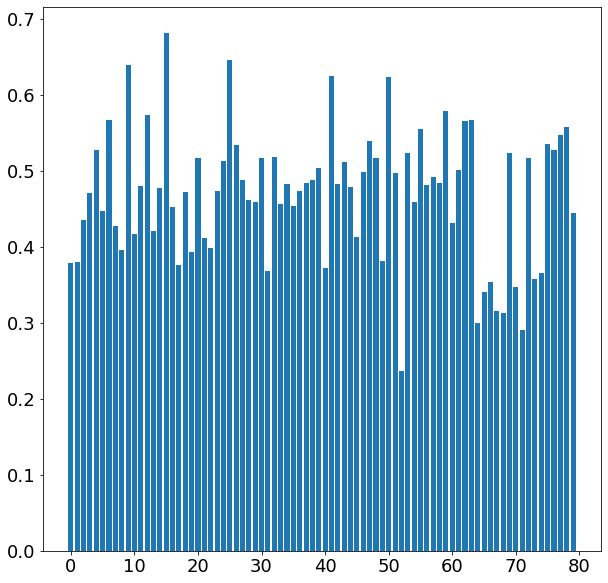

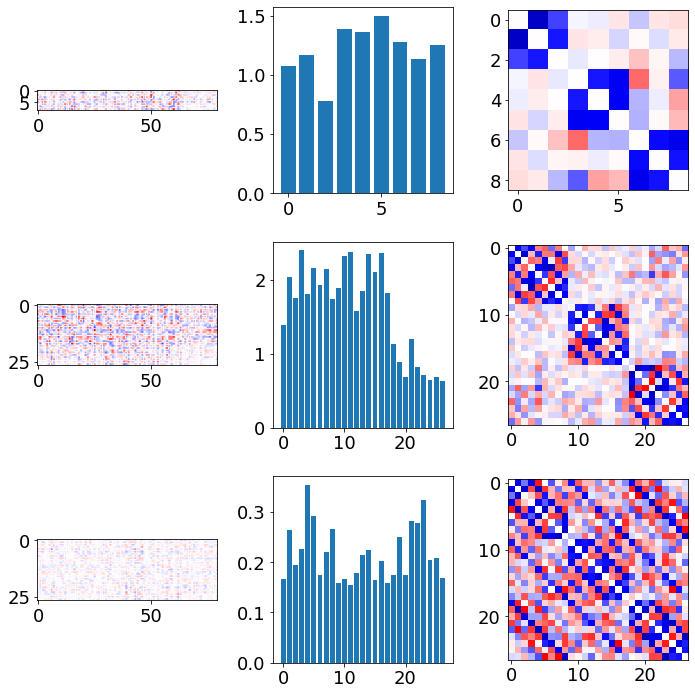

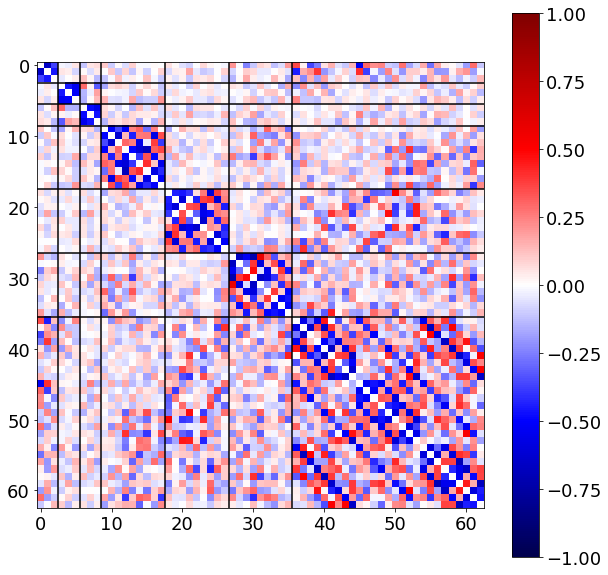

In [138]:
figure = plt.figure()
plt.bar(range(80), global_avg)

figure = plt.figure()
ft_avg_normed = ft_avg/np.sqrt(np.sum(ft_avg**2, 1)[:,None])
plt.subplot(3,3,1).imshow(ft_avg, cmap='seismic', vmin=-1, vmax=1)
plt.subplot(3,3,2).bar(range(9), np.sum(ft_avg**2, 1))
plt.subplot(3,3,3).imshow(ft_avg_normed@ft_avg_normed.T-np.eye(9), cmap='seismic', vmin=-1, vmax=1)

conj_avg_normed = conj_avg/np.sqrt(np.sum(conj_avg**2, 1)[:,None])
plt.subplot(3,3,4).imshow(conj_avg, cmap='seismic', vmin=-1, vmax=1)
plt.subplot(3,3,5).bar(range(27), np.sum(conj_avg**2, 1))
plt.subplot(3,3,6).imshow(conj_avg_normed@conj_avg_normed.T-np.eye(27), cmap='seismic', vmin=-1, vmax=1)

obj_avg_normed = obj_avg/np.sqrt(np.sum(obj_avg**2, 1)[:,None])
plt.subplot(3,3,7).imshow(obj_avg, cmap='seismic', vmin=-1, vmax=1)
plt.subplot(3,3,8).bar(range(27), np.sum(obj_avg**2, 1))
plt.subplot(3,3,9).imshow(obj_avg_normed@obj_avg_normed.T-np.eye(27), cmap='seismic', vmin=-1, vmax=1)

plt.tight_layout()

figure = plt.figure()
plt.imshow(np.concatenate([ft_avg_normed, conj_avg_normed, obj_avg_normed])@np.concatenate([ft_avg_normed, conj_avg_normed, obj_avg_normed]).T-np.eye(63), cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

block_boundaries = [2.5, 5.5, 8.5, 17.5, 26.5, 35.5]
for i in block_boundaries:
    plt.axvline(x=i,color='black')
    plt.axhline(y=i,color='black')

(1) Decompose first layer recurrent weights using SVD to get left/right connectivity vectors.
(2) Match input patterns with left/right connectivity vectors.